In [28]:
import xarray as xr
import xarray
import dask 
import os

In [2]:
# Rather an a strict MSE, for the rainfall, reflectivity, UH, we want to penalize specific behavior 

In [3]:
%%time
in_path = '/work/mflora/wofs-cast-data/train_datasets'
inputs = xr.open_dataset(os.path.join(in_path, 'train_inputs.nc'), chunks={})
inputs = inputs.isel(batch=slice(0, 2))
inputs = dask.compute(inputs)

CPU times: user 17.6 s, sys: 7.48 s, total: 25.1 s
Wall time: 1min 20s


In [6]:
inputs = inputs[0]

In [11]:
predict_vars = ['U', 'V', 'W', 'T', 'T2', 'COMPOSITE_REFL_10CM', 
                'UP_HELI_MAX', 'RAINNC'
               ]

In [17]:
prediction = inputs[predict_vars].isel(time=0)
target = inputs[predict_vars].isel(time=1)

In [50]:
def _mean_preserving_batch(x: xarray.DataArray) -> xarray.DataArray:
    return x.mean([d for d in x.dims if d != 'batch'], skipna=False)


def threshold_tuned_loss(target, prediction, 
                         small_val_thresh, 
                         mid_val_thresh,
                         large_val_thresh, 
                         small_val_penalty=10.0, 
                         mid_val_penalty=15.0, 
                         large_val_penalty=5.0
                        ):
    """
    Custom loss function that penalizes underpredictions above a certain threshold and overpredictions below a certain threshold.

    Parameters:
    - target: xarray.DataArray representing the true target values.
    - prediction: xarray.DataArray representing the predicted values.
    - large_val_thresh: Threshold above which underpredictions are heavily penalized.
    - small_val_thresh: Threshold below which overpredictions are heavily penalized.

    Returns:
    - loss: The calculated loss as an xarray.DataArray.
    """
    
    # Masks
    overpredict_small_val_mask  = (prediction > target) & (target <= small_val_thresh)
    underpredict_mid_val_mask   = (prediction < target) & (target <= mid_val_thresh)
    underpredict_large_val_mask = (prediction < target) & (target > large_val_thresh)
    
    # Loss calculations
    overpredict_loss = xr.where(overpredict_small_val_mask , (prediction - target) * small_val_penalty, 0)
    underpredict_loss_mid = xr.where(underpredict_mid_val_mask, (target - prediction) * mid_val_penalty, 0)
    underpredict_loss_large = xr.where(underpredict_large_val_mask, (target - prediction) * large_val_penalty, 0)

    # Combine loss components
    combined_loss = overpredict_loss + underpredict_loss_mid + underpredict_loss_large
    
    return combined_loss

def custom_loss(predictions, targets): 
    
    custom_loss_params = {'COMPOSITE_REFL_10CM': {'small_val_thresh' : 5.0, # dBZ 
                                                  'mid_val_thresh' : 15., # dBZ
                                                  'large_val_thresh': 40, 

                                                  }, 
                          
                           'UP_HELI_MAX':     {'small_val_thresh' : 5.0, # UH units 
                                               'mid_val_thresh' : 15., # UH units
                                               'large_val_thresh': 60, 

                                                  }, 
                           'RAINNC':         {'small_val_thresh' : 0.1, # mm 
                                                  'mid_val_thresh' : 5.0, # mm
                                                  'large_val_thresh': 25.4 # mm

                                                  }, 
                   
                         }

    all_data_vars = list(targets.data_vars)
    
    custom_loss_vars = custom_loss_params.keys()
    
    standard_vars = [item for item in all_data_vars if item not in custom_loss_vars]
    
    mse_loss = (prediction[standard_vars] - target[standard_vars])**2
    
    for var, params in custom_loss_params.items():
        mse_loss[var] = threshold_tuned_loss(targets[var], predictions[var], **params)
    
    
    return mse_loss
    

In [51]:
mse_loss = custom_loss(prediction, target)

In [58]:
mse_loss['UP_HELI_MAX'].name

'UP_HELI_MAX'

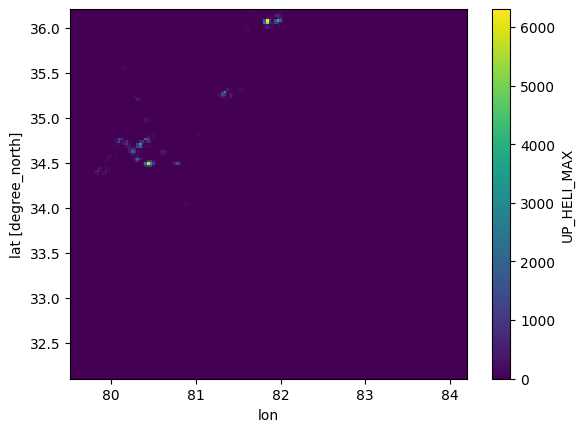

In [56]:
standard_mse_loss = (prediction - target)**2

standard_mse_loss['UP_HELI_MAX'].isel(batch=0).plot()